<a href="https://colab.research.google.com/github/agrawalkunal2/book_recommendation/blob/main/Book_Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Statement
During the last few decades, with the rise of Youtube, Amazon, Netflix, and many other such web services, recommender systems have taken more and more place in our lives. From e-commerce (suggest to buyers articles that could interest them) to online advertisement (suggest to users the right contents, matching their preferences), recommender systems are today unavoidable in our daily online journeys.<BR>
In a very general way, recommender systems are algorithms aimed at suggesting relevant items to users (items being movies to watch, text to read, products to buy, or anything else depending on industries).
<BR>
Recommender systems are really critical in some industries as they can generate a huge amount of income when they are efficient or also be a way to stand out significantly from competitors. The main objective is to create a book recommendation system for users.
<BR>
### Content
The Book-Crossing dataset comprises 3 files.
* Users <BR>
Contains the users. Note that user IDs (   ) have been anonymized and map to integers. Demographic data is provided (   , Age) if available. Otherwise, these
fields contain NULL values.
* Books <BR>
Books are identified by their respective ISBN. Invalid ISBNs have already been removed from the dataset. Moreover, some content-based information is given (Book-Title, Book-Author, Year-Of-Publication, Publisher), obtained from Amazon Web Services. Note that in the case of several authors, only the first is provided. URLs linking to cover images are also given, appearing in three different flavors (Image-URL-S, Image-URL-M, Image-URL-L), i.e., small, medium, large. These URLs point to the
Amazon website.
* Ratings<BR>
Contains the book rating information. Ratings (Book-Rating) are either explicit, expressed on a scale from 1-10 (higher values denoting higher appreciation), or implicit, expressed by 0.

In [400]:
# importing necessary libraries
import pandas as pd
import numpy as np
import math
import random

# importing libraries pertaining to EDA activities
import seaborn as sns
import matplotlib.pyplot as plt

# supressing warnings
import warnings
warnings.filterwarnings('ignore')

In [401]:
# mounting drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [402]:
# loading files for processing
path = "/content/drive/MyDrive/Colab Notebooks/Capstone 4/"
df_books = pd.read_csv(path + "Books.csv")
df_ratings = pd.read_csv(path + "Ratings.csv")
df_users = pd.read_csv(path + "Users.csv")

In [403]:
# taking initial look for df_books
df_books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


At initial look we can say that Image URL is not required for our processing. We will further remove those columns. Also, we will rename columns

In [404]:
# taking initial look for df_ratings
df_ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


Here, we can see that few of the ratings are 0, which according to the Problem Statement are implicit ratings. And then the ratings range from 1 to 10, explicit ratings

In [405]:
# taking initial look for df_users
df_users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


Here, by initial look itself we can observe that there are null values in Age column. We will look further how many null values are there are will decide accordingly.

## Pre-processing
Let's start with preprocessing activities

In [406]:
# shape of dfs
print("Shape of Books is: ",df_books.shape)
print("Shape of users is: ", df_users.shape)
print("Shape of ratings is: ",df_ratings.shape)

Shape of Books is:  (271360, 8)
Shape of users is:  (278858, 3)
Shape of ratings is:  (1149780, 3)


## Checking Duplicate Values

In [407]:
# duplicate values in df_books
len(df_books[df_books.duplicated()])

0

In [408]:
# duplicate values on the basis of user entries and 
len(df_books[df_books.duplicated(subset=['Book-Title','Book-Author'])])

20175

We can see that there were 20175 duplicates in books dataframe. We will remove the same.

In [409]:
# keeping first row and deleting other rows
df_books.drop_duplicates(subset=['Book-Title','Book-Author'], keep="first",inplace=True)
df_books.shape

(251185, 8)

In [410]:
# duplicate values in df_ratings
len(df_ratings[df_ratings.duplicated()])

0

## Renaming columns

In [411]:
# deleting columns related to image urls in df_books
df_books = df_books[["ISBN","Book-Title","Book-Author","Year-Of-Publication","Publisher"]]

In [412]:
df_books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company


In [413]:
## renaming columns of df_books
df_books.rename(columns={"Book-Title":"book","Book-Author":"author","Year-Of-Publication":"year"},inplace=True)

In [414]:
df_books.head()

,ISBN,book,author,year,Publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company


In [415]:
# rename column of df_users
df_users.rename(columns={"User-ID":"user_id"}, inplace= True)

In [416]:
# rename column of df_rating
df_ratings.rename(columns={"User-ID":"user_id","Book-Rating":"book_rating"},inplace=True)

Checking presence of Null Values

In [417]:
# null values in df_books
df_books.isna().sum()

ISBN         0
book         0
author       1
year         0
Publisher    2
dtype: int64

In [418]:
# examining the value of author
df_books[df_books.author.isnull()]

,ISBN,book,author,year,Publisher
187689,9627982032,The Credit Suisse Guide to Managing Your Perso...,NaN,1995,Edinburgh Financial Publishing


We have just 1 value pertaining to author and 2 values pertaining to publisher as null. Since, we are not making any predictions based on either Author or Publication, hence, we can ignore them for now as these can't be imputed by any other value

In [419]:
# null values in df_ratings
df_ratings.isna().sum()

user_id        0
ISBN           0
book_rating    0
dtype: int64

There is no null value present in df_ratings.

In [420]:
# null values in df_users
df_users.isna().sum()

user_id          0
Location         0
Age         110762
dtype: int64

So as we can observe there are huge number of null values present in the df_users. <BR>
Let's try to look at the percentage of null values pertaining to Age column.

In [421]:
len(df_users.user_id.unique())

278858

In [422]:
# percentage of null values in Age
df_users.Age.isnull().sum() * 100 / len(df_users)

39.71985741847105

We have around 40% of cases where the Age is missing from users data.<br>
We need to find a way to impute these values with certain suitable parameter

In [423]:
# unique values of Age column
print(sorted(df_users.Age.unique()))

[nan, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 113.0, 114.0, 115.0, 116.0, 118.0, 119.0, 123.0, 124.0, 127.0, 128.0, 132.0, 133.0, 136.0, 137.0, 138.0, 140.0, 141.0, 143.0, 146.0, 147.0, 148.0, 151.0, 152.0, 156.0, 157.0, 159.0, 162.0, 168.0, 172.0, 175.0, 183.0, 186.0, 189.0, 199.0, 200.0, 201.0, 204.0, 207.0, 208.0, 209.0, 210.0, 212.0, 219.0, 220.0, 223.0, 226.0

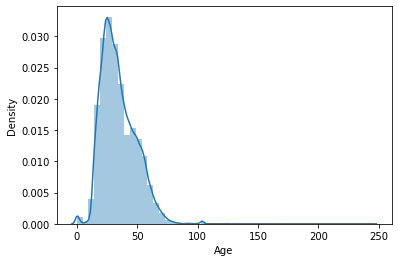

In [424]:
# Plotting Distribution of Age
sns.distplot(df_users['Age'].dropna())

Text(0.5, 1.0, 'Finding outlier data in Age column')

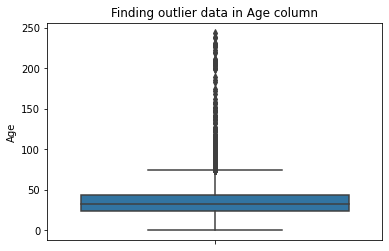

In [425]:
# checking outliers in Age column
sns.boxplot(y="Age", data=df_users)
plt.title('Finding outlier data in Age column')

We can easily see that not only Age column contains lot of null values but also ages that don't make much sense, we can't expect anyone to 250 years old and also there is no point that someone aged 0 would be reading books. We need proper treatment of the data.<BR>
For null values, present in Age, we will try to impute it with random values present that will be between median +- std deviation

In [426]:
# making outlier data present in Age column as nan
df_users.loc[(df_users.Age > 100) | (df_users.Age < 5), 'Age'] = np.nan

In [427]:
# Replacing null values in Age
median = df_users['Age'].median()
std = df_users['Age'].std()
random_age = np.random.randint(median - std, median + std, size = df_users.Age.isnull().sum())
age = df_users['Age'].copy()
age[pd.isnull(age)] = random_age
df_users['Age'] = age
df_users['Age'] = df_users['Age'].astype(int)

In [428]:
print("checking")
df_users.Age.isnull().sum()

checking


0

Text(0.5, 1.0, 'Finding outlier data in Age column')

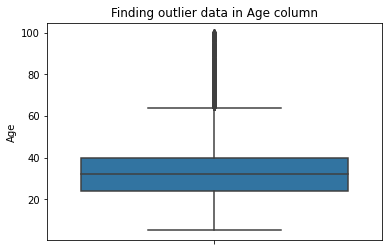

In [429]:
# checking outliers in Age column
sns.boxplot(y="Age", data=df_users)
plt.title('Finding outlier data in Age column')

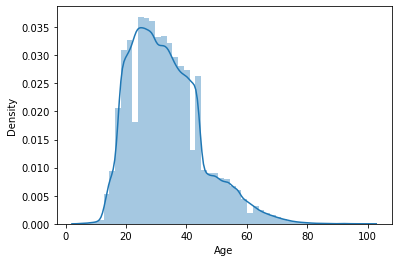

In [430]:
# Plotting Distribution of Age
sns.distplot(df_users['Age'])

## Ratings
Now we will try to check the rating provided by users for the books available

Text(0.5, 1.0, 'Total Ratings')

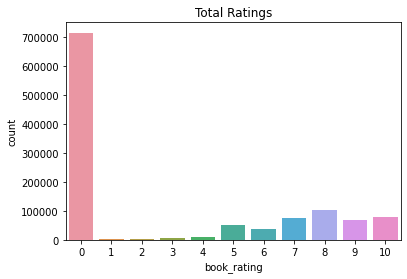

In [431]:
# count of ratings given
sns.countplot(x="book_rating",data=df_ratings)
plt.title("Total Ratings")

In [432]:
df_users.shape

(278858, 3)

In [433]:
len(df_ratings.user_id.unique())

105283

It can be observed that 105283 peoples have given a rating among 278858.

**Extracting Users > 25 ratings** <BR>
To make our data statistically significant, we will try to extract only those users who have given atleast 25 ratings

In [434]:
# extracting user ratings greater than 25
x = df_ratings['user_id'].value_counts() > 25
y = x[x].index  #user_ids
print(y.shape)
df_ratings = df_ratings[df_ratings['user_id'].isin(y)]


(5934,)


In [435]:
len(df_ratings.user_id.unique())

5934

Now we will merge df_ratings with df_books

In [436]:
# merging ratings and books
rating_with_books = df_ratings.merge(df_books, on='ISBN')
rating_with_books.head()

,user_id,ISBN,book_rating,book,author,year,Publisher
0,276847,0446364193,0,Along Came a Spider (Alex Cross Novels),James Patterson,1993,Warner Books
1,278418,0446364193,0,Along Came a Spider (Alex Cross Novels),James Patterson,1993,Warner Books
2,5483,0446364193,0,Along Came a Spider (Alex Cross Novels),James Patterson,1993,Warner Books
3,7346,0446364193,0,Along Came a Spider (Alex Cross Novels),James Patterson,1993,Warner Books
4,8362,0446364193,0,Along Came a Spider (Alex Cross Novels),James Patterson,1993,Warner Books


In [437]:
len(rating_with_books.user_id.unique())

5931

Counting the numbers of ratings given to books

In [438]:
# creating df to get number of ratings
number_rating = rating_with_books.groupby('book')['book_rating'].count().reset_index()

In [439]:
number_rating.head()

,book,book_rating
0,A Light in the Storm: The Civil War Diary of ...,4
1,Always Have Popsicles,1
2,Apple Magic (The Collector's series),1
3,"Ask Lily (Young Women of Faith: Lily Series, ...",1
4,Beyond IBM: Leadership Marketing and Finance ...,1


In [440]:
# renaming book_rating to number of ratings
number_rating.rename(columns={"book_rating": "num_of_ratings"},inplace=True)

In [441]:
number_rating.head()

,book,num_of_ratings
0,A Light in the Storm: The Civil War Diary of ...,4
1,Always Have Popsicles,1
2,Apple Magic (The Collector's series),1
3,"Ask Lily (Young Women of Faith: Lily Series, ...",1
4,Beyond IBM: Leadership Marketing and Finance ...,1


In [442]:
# merging the above created dataframe to rating_with_books df to get total number of ratings columns
final_rating = rating_with_books.merge(number_rating, on='book')

In [443]:
final_rating.head()

,user_id,ISBN,book_rating,book,author,year,Publisher,num_of_ratings
0,276847,0446364193,0,Along Came a Spider (Alex Cross Novels),James Patterson,1993,Warner Books,211
1,278418,0446364193,0,Along Came a Spider (Alex Cross Novels),James Patterson,1993,Warner Books,211
2,5483,0446364193,0,Along Came a Spider (Alex Cross Novels),James Patterson,1993,Warner Books,211
3,7346,0446364193,0,Along Came a Spider (Alex Cross Novels),James Patterson,1993,Warner Books,211
4,8362,0446364193,0,Along Came a Spider (Alex Cross Novels),James Patterson,1993,Warner Books,211


Now, we will keep only those books which have received atleast 50 ratings to get better recommendations

In [444]:
# taking total number of ratings greater than 50
final_rating = final_rating[final_rating['num_of_ratings']>=50]
final_rating.head()

,user_id,ISBN,book_rating,book,author,year,Publisher,num_of_ratings
0,276847,0446364193,0,Along Came a Spider (Alex Cross Novels),James Patterson,1993,Warner Books,211
1,278418,0446364193,0,Along Came a Spider (Alex Cross Novels),James Patterson,1993,Warner Books,211
2,5483,0446364193,0,Along Came a Spider (Alex Cross Novels),James Patterson,1993,Warner Books,211
3,7346,0446364193,0,Along Came a Spider (Alex Cross Novels),James Patterson,1993,Warner Books,211
4,8362,0446364193,0,Along Came a Spider (Alex Cross Novels),James Patterson,1993,Warner Books,211


In [445]:
print("Final Ratings shape is : ", final_rating.shape)

Final Ratings shape is :  (117731, 8)


In [468]:
# merging final_rating dataset with user dataset
data = final_rating.merge(df_users[['user_id', 'Age']], how = 'left',
                on= 'user_id')

In [469]:
data.head()

,user_id,ISBN,book_rating,book,author,year,Publisher,num_of_ratings,Age
0,276847,0446364193,0,Along Came a Spider (Alex Cross Novels),James Patterson,1993,Warner Books,211,27
1,278418,0446364193,0,Along Came a Spider (Alex Cross Novels),James Patterson,1993,Warner Books,211,42
2,5483,0446364193,0,Along Came a Spider (Alex Cross Novels),James Patterson,1993,Warner Books,211,20
3,7346,0446364193,0,Along Came a Spider (Alex Cross Novels),James Patterson,1993,Warner Books,211,49
4,8362,0446364193,0,Along Came a Spider (Alex Cross Novels),James Patterson,1993,Warner Books,211,28


### Exploratory Data Analysis

**Location**

In [446]:
df_users.head()

,user_id,Location,Age
0,1,"nyc, new york, usa",28
1,2,"stockton, california, usa",18
2,3,"moscow, yukon territory, russia",31
3,4,"porto, v.n.gaia, portugal",17
4,5,"farnborough, hants, united kingdom",42


In [447]:
# defining a function to extarct the country names
def get_country(x):
  return x.split(',')[-1]

In [448]:
#applying the function the location column
df_location = df_users.copy(deep=True)
df_location['country'] = df_users['Location'].apply(get_country)

In [449]:
df_location.head()

,user_id,Location,Age,country
0,1,"nyc, new york, usa",28,usa
1,2,"stockton, california, usa",18,usa
2,3,"moscow, yukon territory, russia",31,russia
3,4,"porto, v.n.gaia, portugal",17,portugal
4,5,"farnborough, hants, united kingdom",42,united kingdom


In [450]:
#Identifying what % of customers are coming from different countries
df_location = pd.DataFrame(df_location.country.value_counts(normalize=True)).reset_index()
df_location.columns = ['countries','value_counts']

#Labeling countries with low customer % as other
df_location['countries'] = df_location.apply(lambda x: 'other' if (x['value_counts'] < 0.01 or x['countries'] == '') else x['countries'],axis=1)

#Grouping the customer % from 'other' countries 
df_location = df_location.groupby('countries')['value_counts'].sum().reset_index()

In [451]:
#Every country has now just one occurance
df_location.countries.value_counts()

 italy             1
 australia         1
 portugal          1
 france            1
 canada            1
other              1
 united kingdom    1
 new zealand       1
 netherlands       1
 spain             1
 germany           1
 usa               1
Name: countries, dtype: int64

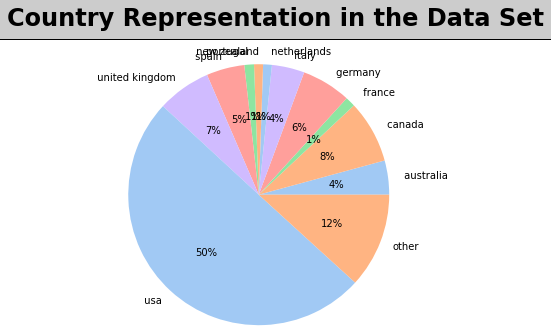

In [452]:
#define Seaborn color palette to use
colors = sns.color_palette('pastel')[0:5]

#create pie chart
plt.title("Country Representation in the Data Set",bbox={'facecolor':'0.8', 'pad':8},fontsize=24, fontdict={"weight": "bold"},y=1.25,x=0.578)
f = plt.pie(df_location['value_counts'], labels = df_location['countries'], colors = colors, autopct='%.0f%%',radius=1.5)

We can see that most of the users come from USA.

In [453]:
len(data['Location'].unique())

2923

**Ratings**

Text(0.5, 1.0, 'Total Ratings')

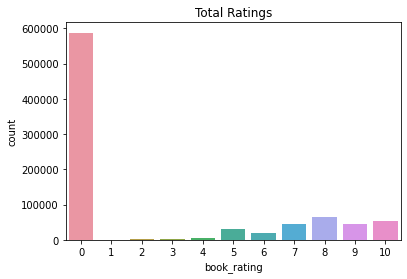

In [454]:
# count of ratings given
sns.countplot(x="book_rating",data=df_ratings)
plt.title("Total Ratings")

We can observe that over here, lot of 0 ratings are there. However, we know that ratings can only be between 1 to 10. <BR>
As per the problem statement, it was stated there are 2 types of ratings one is implicit ratings containing 0s and other is explicit ratings containing ratings between 1 to 10. <BR>
That means we need to consider different approaches for diffrent rating methodologies.

In [455]:
# seperating df_rating into 2 different dataframes
df_ratings_exp = df_ratings[df_ratings['book_rating']>=1]
df_ratings_imp = df_ratings[df_ratings['book_rating'] == 0]

In [456]:
df_ratings_exp.head()

,user_id,ISBN,book_rating
174,276847,3257200552,5
176,276847,3404145909,8
177,276847,3404148576,8
178,276847,3404921178,7
179,276847,3423071516,10


In [457]:
df_ratings_imp.head()

,user_id,ISBN,book_rating
173,276847,0446364193,0
175,276847,3379015180,0
180,276847,3423204885,0
181,276847,3423205806,0
183,276847,3426622610,0


Text(0.5, 1.0, 'Total Ratings')

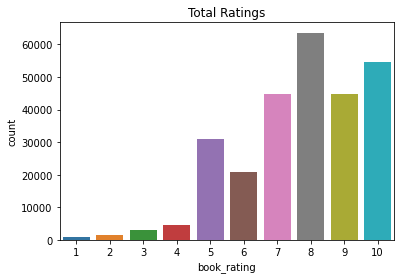

In [458]:
# count of ratings given for explicit case
sns.countplot(x="book_rating",data=df_ratings_exp)
plt.title("Total Ratings")

**Authors vs Rating**

In [459]:
# ratings count per author
auth_rating=final_rating.groupby(['author'])['book_rating'].count().sort_values(ascending=False).reset_index()

In [460]:
auth_rating

,author,book_rating
0,Nora Roberts,4282
1,Stephen King,2850
2,James Patterson,2558
3,Sue Grafton,2307
4,Mary Higgins Clark,2281
...,...,...
963,Bill Brittain,1
964,Bharati Mukherjee,1
965,Katherine Deauxville,1
966,Beverly H. Renner,1


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

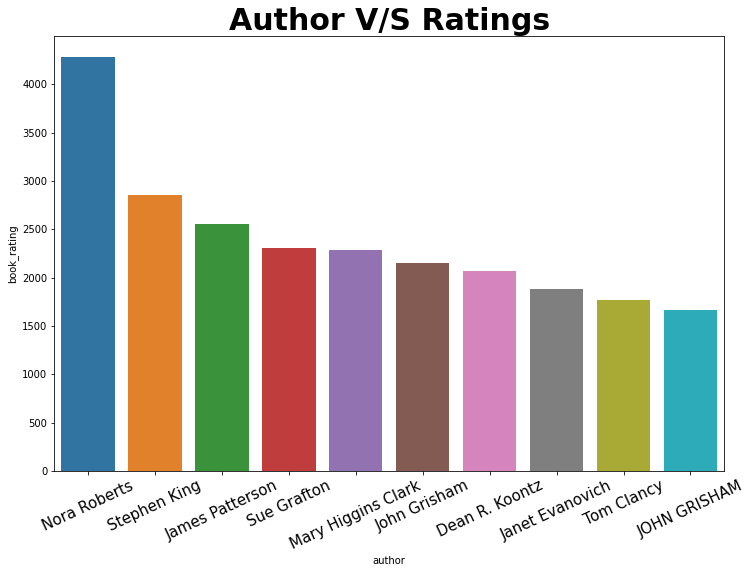

In [461]:
plt.figure(figsize=(12,8))
ax = sns.barplot(x=auth_rating['author'][:10],y=auth_rating['book_rating'][:10])
ax.set_title('Author V/S Ratings', fontsize=30,fontweight='bold')
plt.xticks(fontsize=15,rotation=25)

Here, Nora Roberts has received most number of ratings followed by Stephen King and James Patterson.

**Book vs Rating Counts**

In [462]:
#Book ratings count using group by
book_rating=final_rating.groupby(['book'])['book_rating'].count().sort_values(ascending=False).reset_index()

(array([   0.,  200.,  400.,  600.,  800., 1000., 1200.]),
 <a list of 7 Text major ticklabel objects>)

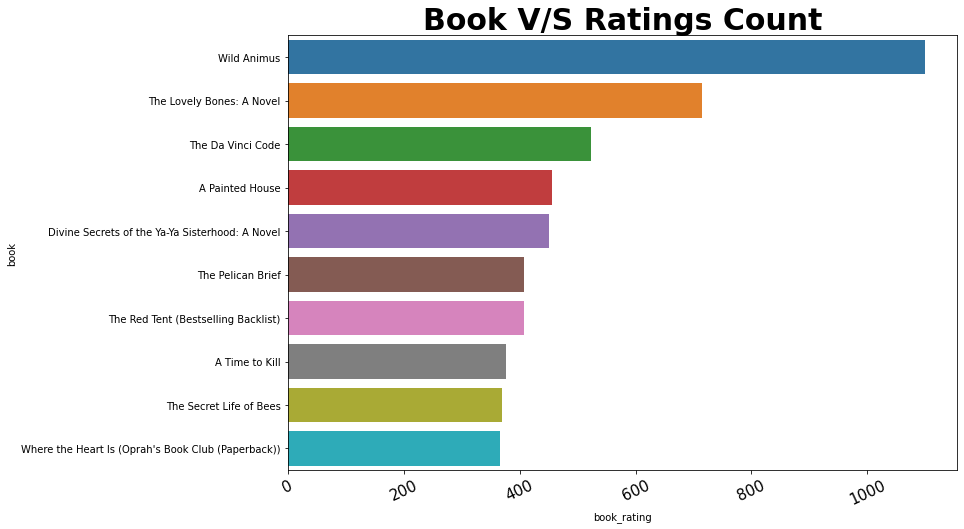

In [463]:
plt.figure(figsize=(12,8))
ax = sns.barplot(y=book_rating['book'][:10],x=book_rating['book_rating'][:10])
ax.set_title('Book V/S Ratings Count', fontsize=30,fontweight='bold')
plt.xticks(fontsize=15,rotation=25)

Most number of ratings has been received for Wild Animus followed by The Lovely Bones and The Da Vinci Code

Adding Average ratings and no. of users rated column for Explicit Ratings

In [464]:
# Create column Rating average 
df_ratings_exp['Avg_Rating']=df_ratings_exp.groupby('ISBN')['book_rating'].transform('mean')
# Create column Rating sum
df_ratings_exp['Total_No_of_Users_Rated']=df_ratings_exp.groupby('ISBN')['book_rating'].transform('count')

In [465]:
df_ratings_exp.head()

,user_id,ISBN,book_rating,Avg_Rating,Total_No_of_Users_Rated
174,276847,3257200552,5,6.333333,3
176,276847,3404145909,8,8.000000,1
177,276847,3404148576,8,7.750000,4
178,276847,3404921178,7,7.000000,4
179,276847,3423071516,10,9.250000,4


In [466]:
final_rating.head()

,user_id,ISBN,book_rating,book,author,year,Publisher,num_of_ratings
0,276847,0446364193,0,Along Came a Spider (Alex Cross Novels),James Patterson,1993,Warner Books,211
1,278418,0446364193,0,Along Came a Spider (Alex Cross Novels),James Patterson,1993,Warner Books,211
2,5483,0446364193,0,Along Came a Spider (Alex Cross Novels),James Patterson,1993,Warner Books,211
3,7346,0446364193,0,Along Came a Spider (Alex Cross Novels),James Patterson,1993,Warner Books,211
4,8362,0446364193,0,Along Came a Spider (Alex Cross Novels),James Patterson,1993,Warner Books,211


In [467]:
df_users

,user_id,Location,Age
0,1,"nyc, new york, usa",28
1,2,"stockton, california, usa",18
2,3,"moscow, yukon territory, russia",31
3,4,"porto, v.n.gaia, portugal",17
4,5,"farnborough, hants, united kingdom",42
...,...,...,...
278853,278854,"portland, oregon, usa",28
278854,278855,"tacoma, washington, united kingdom",50
278855,278856,"brampton, ontario, canada",44
278856,278857,"knoxville, tennessee, usa",42


In [470]:
data.head()

,user_id,ISBN,book_rating,book,author,year,Publisher,num_of_ratings,Age
0,276847,0446364193,0,Along Came a Spider (Alex Cross Novels),James Patterson,1993,Warner Books,211,27
1,278418,0446364193,0,Along Came a Spider (Alex Cross Novels),James Patterson,1993,Warner Books,211,42
2,5483,0446364193,0,Along Came a Spider (Alex Cross Novels),James Patterson,1993,Warner Books,211,20
3,7346,0446364193,0,Along Came a Spider (Alex Cross Novels),James Patterson,1993,Warner Books,211,49
4,8362,0446364193,0,Along Came a Spider (Alex Cross Novels),James Patterson,1993,Warner Books,211,28


In [471]:
final_data = data.copy()

In [472]:
# adding average ratings and no.of users rated
final_data = final_data.merge(df_ratings_exp[['ISBN', 'Avg_Rating', 'Total_No_of_Users_Rated']], how = 'left',
                on = 'ISBN')
final_data.head()

,user_id,ISBN,book_rating,book,author,year,Publisher,num_of_ratings,Age,Avg_Rating,Total_No_of_Users_Rated
0,276847,0446364193,0,Along Came a Spider (Alex Cross Novels),James Patterson,1993,Warner Books,211,27,8.12069,58.0
1,276847,0446364193,0,Along Came a Spider (Alex Cross Novels),James Patterson,1993,Warner Books,211,27,8.12069,58.0
2,276847,0446364193,0,Along Came a Spider (Alex Cross Novels),James Patterson,1993,Warner Books,211,27,8.12069,58.0
3,276847,0446364193,0,Along Came a Spider (Alex Cross Novels),James Patterson,1993,Warner Books,211,27,8.12069,58.0
4,276847,0446364193,0,Along Came a Spider (Alex Cross Novels),James Patterson,1993,Warner Books,211,27,8.12069,58.0
